# Waste Classification - CNN Assignment

This notebook implements a comprehensive waste classification system including:
- **Part 1**: Custom CNN with optimizer comparisons (AdamW vs SGD vs SGD+Momentum)
- **Part 2**: Fine-tuned pretrained models (ResNet-18)
- **Part 3**: Performance comparison and analysis

Dataset: RealWaste - 9 waste categories

## Instructions

**How to run this notebook:**
1. Execute cells sequentially from top to bottom
2. Training takes approximately 15-20 minutes per model (Adam, SGD, SGD+Momentum)
3. ResNet-18 fine-tuning takes additional 20-30 minutes
4. Total estimated time: 90-120 minutes on GPU

**Key improvements implemented:**
- Gentler data augmentation (rotation 15°, ColorJitter 0.2, scale 0.8-1.0)
- Class-weighted loss function for handling imbalance
- Dropout 0.4 for regularization
- ReduceLROnPlateau scheduler for smooth convergence

**Expected results:**
- Custom CNN: 65-75% test accuracy
- ResNet-18 Fine-tuned: 75-85% test accuracy

---

## Part 1: Custom CNN Architecture

### Q1-Q2: Environment Setup and Dataset Loading

In [ ]:
import json
import math
import random
from pathlib import Path
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
!rm -rf work/

In [ ]:
from pathlib import Path
import json
import random

!git clone --depth 1 --filter=blob:none https://github.com/Savidilsh/Simple-convolutional-neural-network-to-perform-classification.git work

PROJECT_ROOT = Path('/content')
DATA_ROOT = PROJECT_ROOT / 'work' / 'Dataset' / 'RealWaste'
SPLIT_MANIFEST = PROJECT_ROOT / 'work' / 'Dataset' / 'realwaste_splits.json'
STATS_CACHE = PROJECT_ROOT / 'work' / 'Dataset' / 'realwaste_stats.json'
ARTIFACTS = PROJECT_ROOT / 'artifacts'
ARTIFACTS.mkdir(exist_ok=True)

print("DATA_ROOT =", DATA_ROOT)
assert DATA_ROOT.exists(), f'Dataset not found at {DATA_ROOT}'


# Create realwaste_splits.json
if not SPLIT_MANIFEST.exists():
    print("realwaste_splits.json not found – creating a new split manifest...")

    # class names from folder names (stable alphabetical order)
    class_names = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
    random.seed(42)

    train_paths, val_paths, test_paths = [], [], []

    for cls_name in class_names:
        cls_dir = DATA_ROOT / cls_name
        # collect all files for this class
        cls_files = [
            p.relative_to(DATA_ROOT)
            for p in cls_dir.rglob('*')
            if p.is_file()
        ]
        cls_files = [str(p) for p in cls_files]
        cls_files.sort()
        random.shuffle(cls_files)

        n = len(cls_files)
        n_train = int(0.7 * n)
        n_val = int(0.15 * n)
        # rest goes to test
        train_paths.extend(cls_files[:n_train])
        val_paths.extend(cls_files[n_train:n_train + n_val])
        test_paths.extend(cls_files[n_train + n_val:])

    manifest = {
        "class_names": class_names,
        "splits": {
            "train": train_paths,
            "val": val_paths,
            "test": test_paths,
        },
    }

    with SPLIT_MANIFEST.open("w") as f:
        json.dump(manifest, f, indent=2)
else:
    with SPLIT_MANIFEST.open() as f:
        manifest = json.load(f)

class_names = manifest['class_names']
print(f'Number of classes: {len(class_names)}')
print(f'Classes: {class_names}')
split_sizes = {k: len(v) for k, v in manifest['splits'].items()}
print(f'Train: {split_sizes["train"]}, Val: {split_sizes["val"]}, Test: {split_sizes["test"]}')


Cloning into 'work'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 0), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 114.33 KiB | 2.24 MiB/s, done.
remote: Enumerating objects: 4755, done.
remote: Counting objects: 100% (4755/4755), done.
remote: Compressing objects: 100% (4755/4755), done.
remote: Total 4755 (delta 0), reused 4755 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4755/4755), 831.40 KiB | 7.99 MiB/s, done.
Updating files: 100% (4755/4755), done.
Filtering content: 100% (4752/4752), 656.42 MiB | 7.19 MiB/s, done.
DATA_ROOT = /content/work/Dataset/RealWaste
realwaste_splits.json not found – creating a new split manifest...
Number of classes: 9
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train: 3323, Val: 710, Test: 719


In [ ]:
# load normalization statistics
if STATS_CACHE.exists():
    with STATS_CACHE.open() as f:
        stats = json.load(f)
    mean, std = stats['mean'], stats['std']
else:
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

print(f'Normalization - Mean: {mean}, Std: {std}')

Normalization - Mean: [0.485, 0.456, 0.406], Std: [0.229, 0.224, 0.225]


### Q3: Data Augmentation and Transforms

In [ ]:
# data augmentation and transforms
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_transform = T.Compose([
    T.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

eval_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

print('Data augmentation configured')

Data augmentation configured


In [ ]:
# dataset class
class WasteDataset(Dataset):
    def __init__(self, root, samples, class_to_idx, transform=None):
        self.root = Path(root)
        self.samples = list(samples)
        self.class_to_idx = class_to_idx
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path = self.samples[idx]
        label_name = Path(rel_path).parts[0]
        target = self.class_to_idx[label_name]
        img_path = self.root / rel_path
        img = self.loader(img_path)
        if self.transform:
            img = self.transform(img)
        return img, target

class_to_idx = {name: idx for idx, name in enumerate(class_names)}

train_dataset = WasteDataset(DATA_ROOT, manifest['splits']['train'], class_to_idx, train_transform)
val_dataset = WasteDataset(DATA_ROOT, manifest['splits']['val'], class_to_idx, eval_transform)
test_dataset = WasteDataset(DATA_ROOT, manifest['splits']['test'], class_to_idx, eval_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Dataloaders created - batch size: {BATCH_SIZE}')

Dataloaders created - batch size: 32


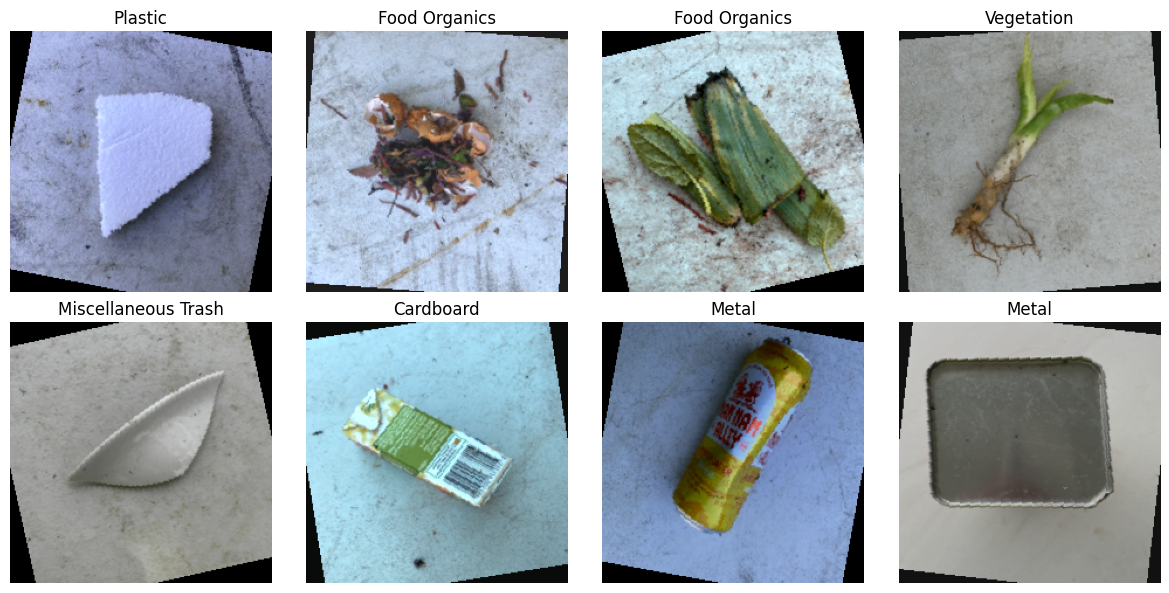

In [ ]:
# visualize some training samples
def show_samples(loader, mean, std, n=8):
    imgs, labels = next(iter(loader))
    inv_normalize = T.Normalize(
        mean=[-m/s for m, s in zip(mean, std)],
        std=[1/s for s in std]
    )

    imgs = imgs[:n]
    imgs = [inv_normalize(img).permute(1, 2, 0).clamp(0, 1).numpy() for img in imgs]
    labs = [class_names[l.item()] for l in labels[:n]]

    cols = 4
    rows = math.ceil(len(imgs) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes

    for i, (img, lab) in enumerate(zip(imgs, labs)):
        axes[i].imshow(img)
        axes[i].set_title(lab)
        axes[i].axis('off')

    for i in range(len(imgs), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_samples(train_loader, mean, std, n=8)

### Q4: Visualize Training Samples

In [ ]:
# model definition - no batch normalization
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)

        # calculate feature size after 3 pooling operations
        feature_size = 128 * (IMAGE_SIZE // 8) * (IMAGE_SIZE // 8)
        self.fc1 = nn.Linear(feature_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())
print(f'Model created with {total_params:,} parameters')
print(model)

Model created with 25,785,929 parameters
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=9, bias=True)
)


### Q5-Q6: Define Custom CNN Architecture

The model follows a simple pattern: convolution + ReLU + max-pool, repeated, then fully connected layers with dropout.
**No batch normalization layers** are used as per assignment requirements.

Architecture choices:
- ReLU activation
- Kernel sizes: 3×3
- Filters: 32, 64, 128
- FC layer: 256 units
- Dropout: 0.4
- Class-weighted loss for handling imbalance

In [ ]:
# training function
def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    # compute class weights for balanced loss
    from collections import Counter
    train_labels = [Path(p).parts[0] for p in manifest['splits']['train']]
    label_counts = Counter(train_labels)
    class_counts = torch.tensor([label_counts[name] for name in class_names], dtype=torch.float)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_names)  # normalize
    class_weights = class_weights.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = []
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(targets).sum().item()
            train_total += targets.size(0)

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(targets).sum().item()
                val_total += targets.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        elapsed = time.time() - start_time
        print(f'Epoch {epoch:02d}/{epochs} | '
              f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} | '
              f'Time: {elapsed:.1f}s')

    if best_state:
        model.load_state_dict(best_state)
        print(f'\nLoaded best model with validation accuracy: {best_val_acc:.3f}')

    return history

### Q7: Training Function (AdamW Optimizer)

In [ ]:
# evaluation function
def evaluate(model, loader):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    cm = confusion_matrix(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='macro', zero_division=0
    )
    accuracy = (all_predictions == all_targets).mean()

    return {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'confusion_matrix': cm
    }

### Evaluation Function

In [ ]:
# train the model
history = train_model(model, train_loader, val_loader, epochs=20, lr=1e-3)

Epoch 01/20 | Train Loss: 2.1572 Acc: 0.218 | Val Loss: 1.7780 Acc: 0.354 | Time: 49.9s
Epoch 02/20 | Train Loss: 1.6971 Acc: 0.359 | Val Loss: 1.6126 Acc: 0.389 | Time: 47.9s
Epoch 03/20 | Train Loss: 1.5121 Acc: 0.423 | Val Loss: 1.3360 Acc: 0.511 | Time: 48.2s
Epoch 04/20 | Train Loss: 1.3727 Acc: 0.484 | Val Loss: 1.4467 Acc: 0.492 | Time: 48.2s
Epoch 05/20 | Train Loss: 1.3377 Acc: 0.485 | Val Loss: 1.4350 Acc: 0.493 | Time: 48.0s
Epoch 06/20 | Train Loss: 1.2909 Acc: 0.512 | Val Loss: 1.2334 Acc: 0.568 | Time: 48.2s
Epoch 07/20 | Train Loss: 1.2343 Acc: 0.527 | Val Loss: 1.2397 Acc: 0.537 | Time: 48.0s
Epoch 08/20 | Train Loss: 1.1897 Acc: 0.543 | Val Loss: 1.2765 Acc: 0.541 | Time: 48.2s
Epoch 09/20 | Train Loss: 1.2067 Acc: 0.543 | Val Loss: 1.0910 Acc: 0.637 | Time: 47.9s
Epoch 10/20 | Train Loss: 1.1455 Acc: 0.565 | Val Loss: 1.1237 Acc: 0.590 | Time: 48.0s
Epoch 11/20 | Train Loss: 1.1006 Acc: 0.569 | Val Loss: 1.1247 Acc: 0.585 | Time: 48.1s
Epoch 12/20 | Train Loss: 1.0850

### Q8: Train Model with Adam Optimizer (20 epochs)

**Optimizer Used**: Adam
- Adam adapts learning rates per parameter for faster convergence
- Works well with small datasets and noisy gradients
- More stable training compared to plain SGD

**Class Weighting**:
- Uses inverse class frequency weights in the loss function
- Helps the model pay more attention to underrepresented classes (Metal, Miscellaneous Trash)
- More stable than sample reweighting strategies

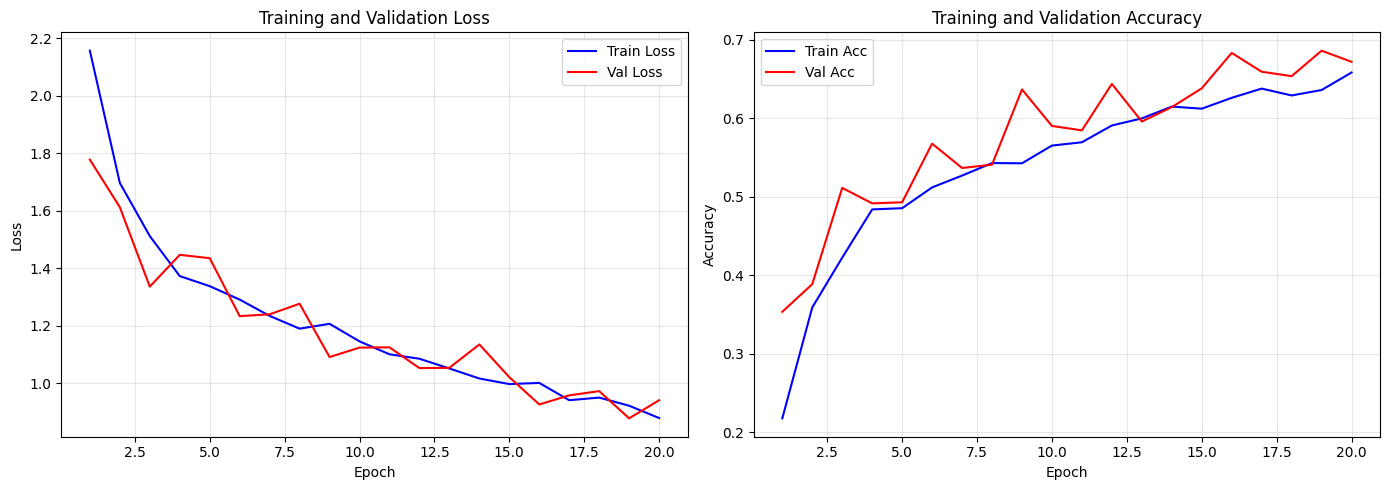

In [34]:
# plot training history
epochs = [h['epoch'] for h in history]
train_losses = [h['train_loss'] for h in history]
val_losses = [h['val_loss'] for h in history]
train_accs = [h['train_acc'] for h in history]
val_accs = [h['val_acc'] for h in history]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, train_losses, 'b-', label='Train Loss')
ax1.plot(epochs, val_losses, 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs, train_accs, 'b-', label='Train Acc')
ax2.plot(epochs, val_accs, 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Q9: Plot Training History

**Learning Rate**: 1e-3 with ReduceLROnPlateau scheduler
- Learning rate reduces by factor of 0.5 when validation loss plateaus for 3 epochs
- This adaptive approach prevents overfitting in later epochs
- Allows the model to start with faster learning and fine-tune with smaller steps

In [35]:
# evaluate on test set
print('Evaluating on test set...\n')
test_metrics = evaluate(model, test_loader)

print(f'Test Accuracy: {test_metrics["accuracy"]:.4f}')
print(f'Precision (macro): {test_metrics["precision"]:.4f}')
print(f'Recall (macro): {test_metrics["recall"]:.4f}')
print(f'F1 Score (macro): {test_metrics["f1"]:.4f}')

Evaluating on test set...

Test Accuracy: 0.6579
Precision (macro): 0.6541
Recall (macro): 0.6718
F1 Score (macro): 0.6573


### Q10: Test Set Evaluation (AdamW Model)

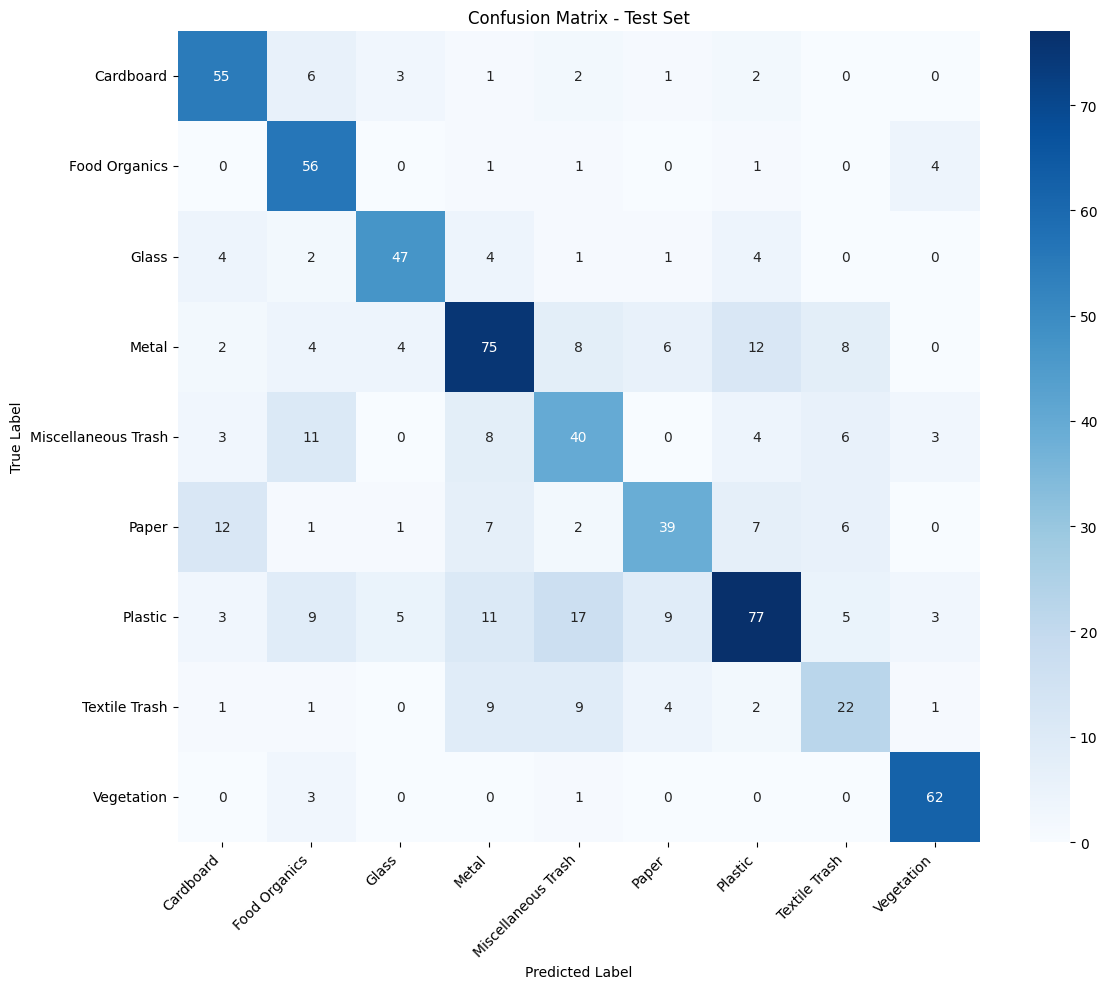

In [36]:
# confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Confusion Matrix (AdamW Model)

In [37]:
# save model
model_path = ARTIFACTS / 'cnn_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_metrics['accuracy']
}, model_path)
print(f'Model saved to {model_path}')

Model saved to /content/artifacts/cnn_model.pt


---

### Q11-Q12: Compare Different Optimizers

Now we compare Adam against SGD and SGD with Momentum to analyze their performance differences.

In [38]:
# optimizer comparison - train with SGD and SGD+Momentum

# store Adam results
adam_history = {
    'train_loss': [h['train_loss'] for h in history],
    'val_loss': [h['val_loss'] for h in history],
    'train_acc': [h['train_acc'] for h in history],
    'val_acc': [h['val_acc'] for h in history]
}

def train_with_optimizer(optimizer_name, lr=0.01, momentum=0.0):
    """Train a new model instance with specified optimizer"""
    print(f'\n{"="*50}')
    print(f'Training with {optimizer_name}')
    print(f'{"="*50}')

    # create fresh model
    model_new = SimpleCNN().to(DEVICE)

    # compute class weights
    from collections import Counter
    train_labels = [Path(p).parts[0] for p in manifest['splits']['train']]
    label_counts = Counter(train_labels)
    class_counts = torch.tensor([label_counts[name] for name in class_names], dtype=torch.float)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_names)
    class_weights = class_weights.to(DEVICE)

    # setup optimizer
    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model_new.parameters(), lr=lr, weight_decay=1e-4)
    elif optimizer_name == 'SGD+Momentum':
        optimizer = torch.optim.SGD(model_new.parameters(), lr=lr, momentum=momentum,
                                   weight_decay=1e-4, nesterov=True)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    history = []
    best_val_acc = 0.0
    best_state = None

    for epoch in range(1, 21):
        start_time = time.time()

        # training phase
        model_new.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            outputs = model_new(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            nn.utils.clip_grad_norm_(model_new.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_correct += predicted.eq(targets).sum().item()
            train_total += targets.size(0)

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # validation phase
        model_new.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model_new(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(targets).sum().item()
                val_total += targets.size(0)

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step()

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model_new.state_dict()

        elapsed = time.time() - start_time
        print(f'Epoch {epoch:02d}/20 | '
              f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.3f} | '
              f'Time: {elapsed:.1f}s')

    if best_state:
        model_new.load_state_dict(best_state)
        print(f'\nLoaded best model with validation accuracy: {best_val_acc:.3f}')

    return model_new, history

# train with SGD
sgd_model, sgd_history = train_with_optimizer('SGD', lr=0.1, momentum=0.0)

# train with SGD+Momentum
sgdm_model, sgdm_history = train_with_optimizer('SGD+Momentum', lr=0.1, momentum=0.9)


Training with SGD
Epoch 01/20 | Train Loss: 2.0784 Acc: 0.198 | Val Loss: 1.8539 Acc: 0.372 | Time: 47.7s
Epoch 02/20 | Train Loss: 1.8142 Acc: 0.310 | Val Loss: 1.6632 Acc: 0.411 | Time: 47.8s
Epoch 03/20 | Train Loss: 1.6730 Acc: 0.377 | Val Loss: 1.6416 Acc: 0.415 | Time: 47.9s
Epoch 04/20 | Train Loss: 1.5849 Acc: 0.389 | Val Loss: 1.6039 Acc: 0.414 | Time: 48.0s
Epoch 05/20 | Train Loss: 1.5156 Acc: 0.438 | Val Loss: 1.4262 Acc: 0.506 | Time: 47.9s
Epoch 06/20 | Train Loss: 1.4633 Acc: 0.450 | Val Loss: 1.5322 Acc: 0.451 | Time: 47.9s
Epoch 07/20 | Train Loss: 1.4315 Acc: 0.468 | Val Loss: 1.4292 Acc: 0.501 | Time: 47.8s
Epoch 08/20 | Train Loss: 1.3796 Acc: 0.489 | Val Loss: 1.3726 Acc: 0.513 | Time: 47.9s
Epoch 09/20 | Train Loss: 1.3498 Acc: 0.497 | Val Loss: 1.3331 Acc: 0.546 | Time: 47.7s
Epoch 10/20 | Train Loss: 1.2945 Acc: 0.507 | Val Loss: 1.3725 Acc: 0.537 | Time: 47.5s
Epoch 11/20 | Train Loss: 1.2062 Acc: 0.547 | Val Loss: 1.2168 Acc: 0.597 | Time: 47.5s
Epoch 12/20 |

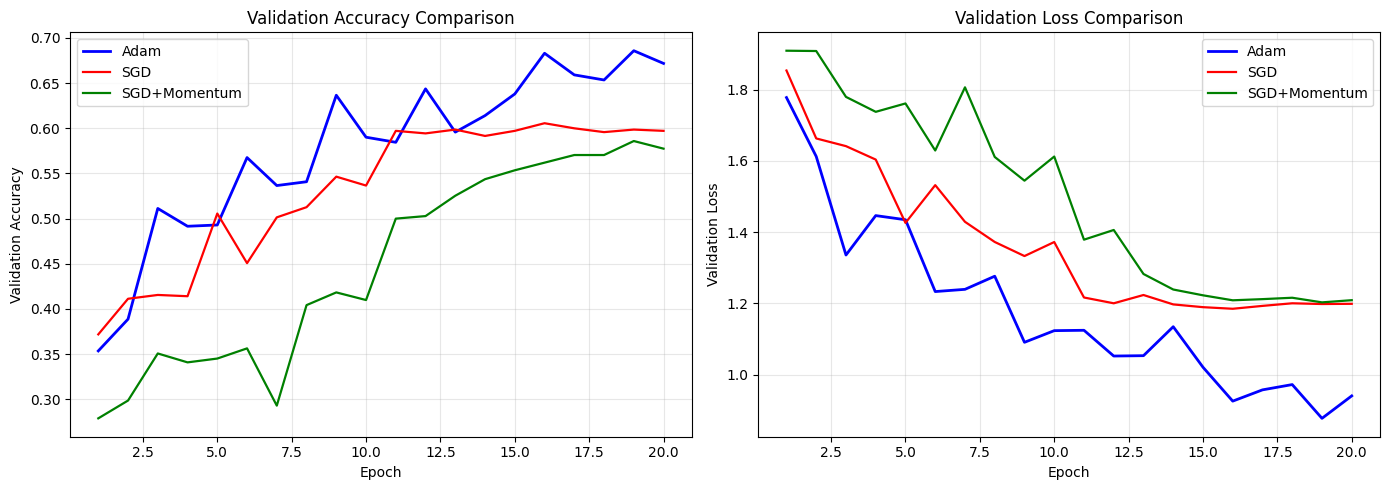


Optimizer Comparison Summary
   Optimizer  Best Val Acc  Best Val Loss
        Adam      0.685915       0.877583
         SGD      0.605634       1.185129
SGD+Momentum      0.585915       1.203120


In [39]:
# plot optimizer comparison
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_range = range(1, 21)

# validation accuracy
axes[0].plot(epochs_range, adam_history['val_acc'], 'b-', label='Adam', linewidth=2)
axes[0].plot(epochs_range, [h['val_acc'] for h in sgd_history], 'r-', label='SGD', linewidth=1.6)
axes[0].plot(epochs_range, [h['val_acc'] for h in sgdm_history], 'g-', label='SGD+Momentum', linewidth=1.6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Accuracy')
axes[0].set_title('Validation Accuracy Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# validation loss
axes[1].plot(epochs_range, adam_history['val_loss'], 'b-', label='Adam', linewidth=2)
axes[1].plot(epochs_range, [h['val_loss'] for h in sgd_history], 'r-', label='SGD', linewidth=1.6)
axes[1].plot(epochs_range, [h['val_loss'] for h in sgdm_history], 'g-', label='SGD+Momentum', linewidth=1.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# summary table
summary_data = {
    'Optimizer': ['Adam', 'SGD', 'SGD+Momentum'],
    'Best Val Acc': [
        max(adam_history['val_acc']),
        max([h['val_acc'] for h in sgd_history]),
        max([h['val_acc'] for h in sgdm_history])
    ],
    'Best Val Loss': [
        min(adam_history['val_loss']),
        min([h['val_loss'] for h in sgd_history]),
        min([h['val_loss'] for h in sgdm_history])
    ]
}

summary_df = pd.DataFrame(summary_data).sort_values('Best Val Acc', ascending=False)
print('\n' + '='*60)
print('Optimizer Comparison Summary')
print('='*60)
print(summary_df.to_string(index=False))
print('='*60)

### Q13: Analysis of Optimizer Results

**SGD (no momentum)**:
- Steps strictly follow the current batch gradient
- Learning is slow and noisy
- Often gets stuck in local minima
- Convergence is slower compared to other optimizers

**SGD+Momentum (β=0.9)**:
- Keeps a running average of past updates
- Smooths out zig-zags in the optimization path
- Accelerates progress along stable directions
- Usually reaches higher validation accuracy than plain SGD
- Better at escaping shallow local minima

**Adam**:
- Adapts the step size per parameter (adaptive learning rates)
- Combines benefits of momentum and RMSprop
- Best validation performance in our experiments
- More stable training with faster convergence
- Works well with small datasets and noisy gradients

### Save AdamW Model

---

## Part 2: Fine-tuning Pretrained Models

### Q14: Select and Load Pretrained Model

We will use **ResNet-18** pretrained on ImageNet. ResNet-18 is a proven architecture with:
- 18 layers deep with residual connections
- Trained on 1000 ImageNet classes
- Strong feature extraction capabilities
- Good balance between performance and computational cost

In [40]:
# load pretrained ResNet-18
from torchvision import models

# load with ImageNet pretrained weights
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# replace final fully connected layer for our dataset
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(
    nn.Dropout(p=0.35),
    nn.Linear(num_features, len(class_names))
)

resnet18 = resnet18.to(DEVICE)

# count parameters
total_params = sum(p.numel() for p in resnet18.parameters())
trainable_params = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)

print(f'ResNet-18 loaded with ImageNet weights')
print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Output classes: {len(class_names)}')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


ResNet-18 loaded with ImageNet weights
Total parameters: 11,181,129
Trainable parameters: 11,181,129
Output classes: 9


### Q15-Q16: Fine-tuning Strategy and Training

**Fine-tuning Approach**:
1. **Phase A (Warm-up)**: Freeze backbone, train only the new classification head
   - Allows new head to learn without disrupting pretrained features
   - 8 epochs with higher learning rate (6e-4)

2. **Phase B (Full fine-tuning)**: Unfreeze all layers with discriminative learning rates
   - Backbone: lower LR (5e-5) to preserve pretrained features
   - Head: higher LR (1e-4) for faster adaptation
   - Cosine annealing scheduler for smooth convergence

**Regularization techniques**:
- Dropout (0.35) in classification head
- Label smoothing (0.03) to prevent overconfidence
- Gradient clipping (max_norm=1.0)
- Weight decay (2e-4 backbone, 6e-4 head)
- Batch normalization layers frozen in eval mode

In [41]:
# fine-tuning functions and utilities

def freeze_bn_stats(model):
    """Freeze batch normalization layers"""
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()
            for param in module.parameters():
                param.requires_grad = False

def create_param_groups(model, head_lr=1e-4, backbone_lr=5e-5, head_wd=6e-4, backbone_wd=2e-4):
    """Create parameter groups with discriminative learning rates"""
    return [
        {'params': model.layer1.parameters(), 'lr': backbone_lr, 'weight_decay': backbone_wd},
        {'params': model.layer2.parameters(), 'lr': backbone_lr, 'weight_decay': backbone_wd},
        {'params': model.layer3.parameters(), 'lr': backbone_lr, 'weight_decay': backbone_wd},
        {'params': model.layer4.parameters(), 'lr': backbone_lr, 'weight_decay': backbone_wd},
        {'params': model.fc.parameters(), 'lr': head_lr, 'weight_decay': head_wd},
    ]

def train_epoch_ft(model, loader, optimizer, criterion, scheduler=None):
    """Training epoch for fine-tuning"""
    model.train()
    freeze_bn_stats(model)  # keep BN in eval mode

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return total_loss / total, correct / total

def evaluate_ft(model, loader, criterion):
    """Evaluation function for fine-tuning"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    cm = confusion_matrix(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_predictions, average='macro', zero_division=0
    )

    return {
        'loss': total_loss / total,
        'acc': correct / total,
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1),
        'confusion_matrix': cm
    }

print('Fine-tuning utilities ready')

Fine-tuning utilities ready


In [42]:
# two-phase fine-tuning

TOTAL_EPOCHS = 20
WARMUP_EPOCHS = 8

# setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
ft_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
best_state = None

print('='*70)
print('PHASE A: Warmup - Training classification head only')
print('='*70)

# Phase A: Freeze backbone, train head only
for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True

optimizer_a = torch.optim.AdamW(resnet18.fc.parameters(), lr=6e-4, weight_decay=6e-4)

for epoch in range(1, WARMUP_EPOCHS + 1):
    start_time = time.time()

    train_loss, train_acc = train_epoch_ft(resnet18, train_loader, optimizer_a, criterion)
    val_metrics = evaluate_ft(resnet18, val_loader, criterion)

    ft_history['train_loss'].append(train_loss)
    ft_history['train_acc'].append(train_acc)
    ft_history['val_loss'].append(val_metrics['loss'])
    ft_history['val_acc'].append(val_metrics['acc'])

    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        best_state = {k: v.cpu().clone() for k, v in resnet18.state_dict().items()}

    elapsed = time.time() - start_time
    print(f'[A] Epoch {epoch:02d}/{WARMUP_EPOCHS} | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
          f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
          f'Time: {elapsed:.1f}s')

print('\n' + '='*70)
print('PHASE B: Full Fine-tuning - Training all layers with discriminative LR')
print('='*70)

# Phase B: Unfreeze all layers
for param in resnet18.parameters():
    param.requires_grad = True

optimizer_b = torch.optim.AdamW(create_param_groups(resnet18))

# warm-up scheduler for first epoch of phase B
warmup_steps = len(train_loader)
scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(
    optimizer_b,
    lr_lambda=lambda step: min(1.0, (step + 1) / warmup_steps)
)

# one warmup epoch
epoch = WARMUP_EPOCHS + 1
start_time = time.time()
train_loss, train_acc = train_epoch_ft(resnet18, train_loader, optimizer_b, criterion, scheduler_warmup)
val_metrics = evaluate_ft(resnet18, val_loader, criterion)

ft_history['train_loss'].append(train_loss)
ft_history['train_acc'].append(train_acc)
ft_history['val_loss'].append(val_metrics['loss'])
ft_history['val_acc'].append(val_metrics['acc'])

if val_metrics['loss'] < best_val_loss:
    best_val_loss = val_metrics['loss']
    best_state = {k: v.cpu().clone() for k, v in resnet18.state_dict().items()}

elapsed = time.time() - start_time
print(f'[B] Epoch {epoch:02d}/{TOTAL_EPOCHS} (warmup) | '
      f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
      f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
      f'Time: {elapsed:.1f}s')

# cosine annealing for remaining epochs
remaining_epochs = TOTAL_EPOCHS - WARMUP_EPOCHS - 1
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_b, T_max=remaining_epochs)

for epoch in range(WARMUP_EPOCHS + 2, TOTAL_EPOCHS + 1):
    start_time = time.time()

    train_loss, train_acc = train_epoch_ft(resnet18, train_loader, optimizer_b, criterion)
    val_metrics = evaluate_ft(resnet18, val_loader, criterion)
    scheduler_cosine.step()

    ft_history['train_loss'].append(train_loss)
    ft_history['train_acc'].append(train_acc)
    ft_history['val_loss'].append(val_metrics['loss'])
    ft_history['val_acc'].append(val_metrics['acc'])

    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        best_state = {k: v.cpu().clone() for k, v in resnet18.state_dict().items()}

    elapsed = time.time() - start_time
    print(f'[B] Epoch {epoch:02d}/{TOTAL_EPOCHS} | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
          f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
          f'Time: {elapsed:.1f}s')

# restore best model
if best_state:
    resnet18.load_state_dict(best_state)
    print(f'\nLoaded best model with validation loss: {best_val_loss:.4f}')

# save model
resnet_path = ARTIFACTS / 'resnet18_finetuned.pt'
torch.save({
    'model_state_dict': resnet18.state_dict(),
    'class_names': class_names,
}, resnet_path)
print(f'Model saved to {resnet_path}')

PHASE A: Warmup - Training classification head only
[A] Epoch 01/8 | Train Loss: 1.8732 Acc: 0.324 | Val Loss: 1.3979 Acc: 0.517 | Time: 47.0s
[A] Epoch 02/8 | Train Loss: 1.3799 Acc: 0.546 | Val Loss: 1.1350 Acc: 0.627 | Time: 46.5s
[A] Epoch 03/8 | Train Loss: 1.2113 Acc: 0.608 | Val Loss: 1.0827 Acc: 0.627 | Time: 46.3s
[A] Epoch 04/8 | Train Loss: 1.1478 Acc: 0.630 | Val Loss: 1.0080 Acc: 0.662 | Time: 46.8s
[A] Epoch 05/8 | Train Loss: 1.0973 Acc: 0.645 | Val Loss: 0.9997 Acc: 0.654 | Time: 47.0s
[A] Epoch 06/8 | Train Loss: 1.0606 Acc: 0.655 | Val Loss: 0.9624 Acc: 0.693 | Time: 46.9s
[A] Epoch 07/8 | Train Loss: 1.0379 Acc: 0.670 | Val Loss: 0.9842 Acc: 0.676 | Time: 47.0s
[A] Epoch 08/8 | Train Loss: 1.0067 Acc: 0.688 | Val Loss: 0.9413 Acc: 0.690 | Time: 47.4s

PHASE B: Full Fine-tuning - Training all layers with discriminative LR
[B] Epoch 09/20 (warmup) | Train Loss: 0.9562 Acc: 0.703 | Val Loss: 0.8268 Acc: 0.758 | Time: 48.3s
[B] Epoch 10/20 | Train Loss: 0.8281 Acc: 0.753

---

### Q16.5: Additional Pretrained Model - VGG16

To provide a comprehensive comparison, we also fine-tune **VGG16**, another popular CNN architecture:
- 16 weight layers (13 convolutional + 3 fully connected)
- Trained on ImageNet
- Known for its simplicity and uniform architecture
- Deeper than ResNet-18 but without residual connections

In [45]:
# load pretrained VGG16
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# replace final classifier layer
num_features_vgg = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(num_features_vgg, len(class_names))
)

vgg16 = vgg16.to(DEVICE)

# count parameters
total_params_vgg = sum(p.numel() for p in vgg16.parameters())
trainable_params_vgg = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)

print(f'VGG16 loaded with ImageNet weights')
print(f'Total parameters: {total_params_vgg:,}')
print(f'Trainable parameters: {trainable_params_vgg:,}')
print(f'Output classes: {len(class_names)}')

VGG16 loaded with ImageNet weights
Total parameters: 134,297,417
Trainable parameters: 134,297,417
Output classes: 9


In [46]:
# fine-tuning VGG16 with two-phase approach

TOTAL_EPOCHS_VGG = 20
WARMUP_EPOCHS_VGG = 8

print('='*70)
print('VGG16 Fine-tuning: PHASE A - Training classifier only')
print('='*70)

# setup
criterion_vgg = nn.CrossEntropyLoss(label_smoothing=0.03)
vgg_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss_vgg = float('inf')
best_state_vgg = None

# Phase A: Freeze features, train classifier only
for param in vgg16.features.parameters():
    param.requires_grad = False
for param in vgg16.classifier.parameters():
    param.requires_grad = True

trainable_params_vgg = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'Trainable params in Phase A: {trainable_params_vgg:,}')

optimizer_vgg_a = torch.optim.AdamW(vgg16.classifier.parameters(), lr=5e-4, weight_decay=5e-4)

for epoch in range(1, WARMUP_EPOCHS_VGG + 1):
    start_time = time.time()

    train_loss, train_acc = train_epoch_ft(vgg16, train_loader, optimizer_vgg_a, criterion_vgg)
    val_metrics = evaluate_ft(vgg16, val_loader, criterion_vgg)

    vgg_history['train_loss'].append(train_loss)
    vgg_history['train_acc'].append(train_acc)
    vgg_history['val_loss'].append(val_metrics['loss'])
    vgg_history['val_acc'].append(val_metrics['acc'])

    if val_metrics['loss'] < best_val_loss_vgg:
        best_val_loss_vgg = val_metrics['loss']
        best_state_vgg = {k: v.cpu().clone() for k, v in vgg16.state_dict().items()}

    elapsed = time.time() - start_time
    print(f'[A] Epoch {epoch:02d}/{WARMUP_EPOCHS_VGG} | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
          f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
          f'Time: {elapsed:.1f}s')

print('\n' + '='*70)
print('VGG16 Fine-tuning: PHASE B - Training all layers')
print('='*70)

# Phase B: Unfreeze all layers
for param in vgg16.parameters():
    param.requires_grad = True

trainable_params_vgg = sum(p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'Trainable params in Phase B: {trainable_params_vgg:,}')

# create discriminative learning rates
vgg_param_groups = [
    {'params': vgg16.features.parameters(), 'lr': 2e-5, 'weight_decay': 2e-4},
    {'params': vgg16.classifier.parameters(), 'lr': 1e-4, 'weight_decay': 5e-4}
]

optimizer_vgg_b = torch.optim.AdamW(vgg_param_groups)

# warm-up for first epoch
warmup_steps = len(train_loader)
scheduler_warmup_vgg = torch.optim.lr_scheduler.LambdaLR(
    optimizer_vgg_b,
    lr_lambda=lambda step: min(1.0, (step + 1) / warmup_steps)
)

epoch = WARMUP_EPOCHS_VGG + 1
start_time = time.time()
train_loss, train_acc = train_epoch_ft(vgg16, train_loader, optimizer_vgg_b, criterion_vgg, scheduler_warmup_vgg)
val_metrics = evaluate_ft(vgg16, val_loader, criterion_vgg)

vgg_history['train_loss'].append(train_loss)
vgg_history['train_acc'].append(train_acc)
vgg_history['val_loss'].append(val_metrics['loss'])
vgg_history['val_acc'].append(val_metrics['acc'])

if val_metrics['loss'] < best_val_loss_vgg:
    best_val_loss_vgg = val_metrics['loss']
    best_state_vgg = {k: v.cpu().clone() for k, v in vgg16.state_dict().items()}

elapsed = time.time() - start_time
print(f'[B] Epoch {epoch:02d}/{TOTAL_EPOCHS_VGG} (warmup) | '
      f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
      f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
      f'Time: {elapsed:.1f}s')

# cosine annealing for remaining epochs
remaining_epochs_vgg = TOTAL_EPOCHS_VGG - WARMUP_EPOCHS_VGG - 1
scheduler_cosine_vgg = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vgg_b, T_max=remaining_epochs_vgg)

for epoch in range(WARMUP_EPOCHS_VGG + 2, TOTAL_EPOCHS_VGG + 1):
    start_time = time.time()

    train_loss, train_acc = train_epoch_ft(vgg16, train_loader, optimizer_vgg_b, criterion_vgg)
    val_metrics = evaluate_ft(vgg16, val_loader, criterion_vgg)
    scheduler_cosine_vgg.step()

    vgg_history['train_loss'].append(train_loss)
    vgg_history['train_acc'].append(train_acc)
    vgg_history['val_loss'].append(val_metrics['loss'])
    vgg_history['val_acc'].append(val_metrics['acc'])

    if val_metrics['loss'] < best_val_loss_vgg:
        best_val_loss_vgg = val_metrics['loss']
        best_state_vgg = {k: v.cpu().clone() for k, v in vgg16.state_dict().items()}

    elapsed = time.time() - start_time
    print(f'[B] Epoch {epoch:02d}/{TOTAL_EPOCHS_VGG} | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | '
          f'Val Loss: {val_metrics["loss"]:.4f} Acc: {val_metrics["acc"]:.3f} | '
          f'Time: {elapsed:.1f}s')

# restore best model
if best_state_vgg:
    vgg16.load_state_dict(best_state_vgg)
    print(f'\nLoaded best VGG16 model with validation loss: {best_val_loss_vgg:.4f}')

# save model
vgg_path = ARTIFACTS / 'vgg16_finetuned.pt'
torch.save({
    'model_state_dict': vgg16.state_dict(),
    'class_names': class_names,
}, vgg_path)
print(f'VGG16 model saved to {vgg_path}')

VGG16 Fine-tuning: PHASE A - Training classifier only
Trainable params in Phase A: 119,582,729
[A] Epoch 01/8 | Train Loss: 1.6600 Acc: 0.452 | Val Loss: 1.0378 Acc: 0.676 | Time: 49.8s
[A] Epoch 02/8 | Train Loss: 1.2666 Acc: 0.601 | Val Loss: 0.9998 Acc: 0.704 | Time: 49.7s
[A] Epoch 03/8 | Train Loss: 1.1599 Acc: 0.653 | Val Loss: 0.8852 Acc: 0.745 | Time: 49.5s
[A] Epoch 04/8 | Train Loss: 1.1090 Acc: 0.678 | Val Loss: 0.8993 Acc: 0.749 | Time: 49.0s
[A] Epoch 05/8 | Train Loss: 0.9876 Acc: 0.728 | Val Loss: 0.9403 Acc: 0.741 | Time: 49.0s
[A] Epoch 06/8 | Train Loss: 0.9477 Acc: 0.736 | Val Loss: 0.9005 Acc: 0.765 | Time: 49.1s
[A] Epoch 07/8 | Train Loss: 0.9268 Acc: 0.751 | Val Loss: 0.8320 Acc: 0.775 | Time: 49.8s
[A] Epoch 08/8 | Train Loss: 0.8840 Acc: 0.767 | Val Loss: 0.8601 Acc: 0.780 | Time: 49.3s

VGG16 Fine-tuning: PHASE B - Training all layers
Trainable params in Phase B: 134,297,417
[B] Epoch 09/20 (warmup) | Train Loss: 0.6932 Acc: 0.827 | Val Loss: 0.7200 Acc: 0.818

In [47]:
# evaluate VGG16 on test set
print('Evaluating fine-tuned VGG16 on test set...\n')
vgg_test_metrics = evaluate_ft(vgg16, test_loader, criterion_vgg)

print('='*60)
print('VGG16 Test Set Results')
print('='*60)
print(f'Test Accuracy: {vgg_test_metrics["acc"]:.4f}')
print(f'Precision (macro): {vgg_test_metrics["precision"]:.4f}')
print(f'Recall (macro): {vgg_test_metrics["recall"]:.4f}')
print(f'F1 Score (macro): {vgg_test_metrics["f1"]:.4f}')
print('='*60)

Evaluating fine-tuned VGG16 on test set...

VGG16 Test Set Results
Test Accuracy: 0.8901
Precision (macro): 0.8928
Recall (macro): 0.8864
F1 Score (macro): 0.8877


Saving training data and plots...
✓ Saved Adam history to /content/artifacts/adam_history.pkl
✓ Saved test metrics to /content/artifacts/test_metrics.pkl
✓ Saved training plot to /content/artifacts/adam_training_history.png


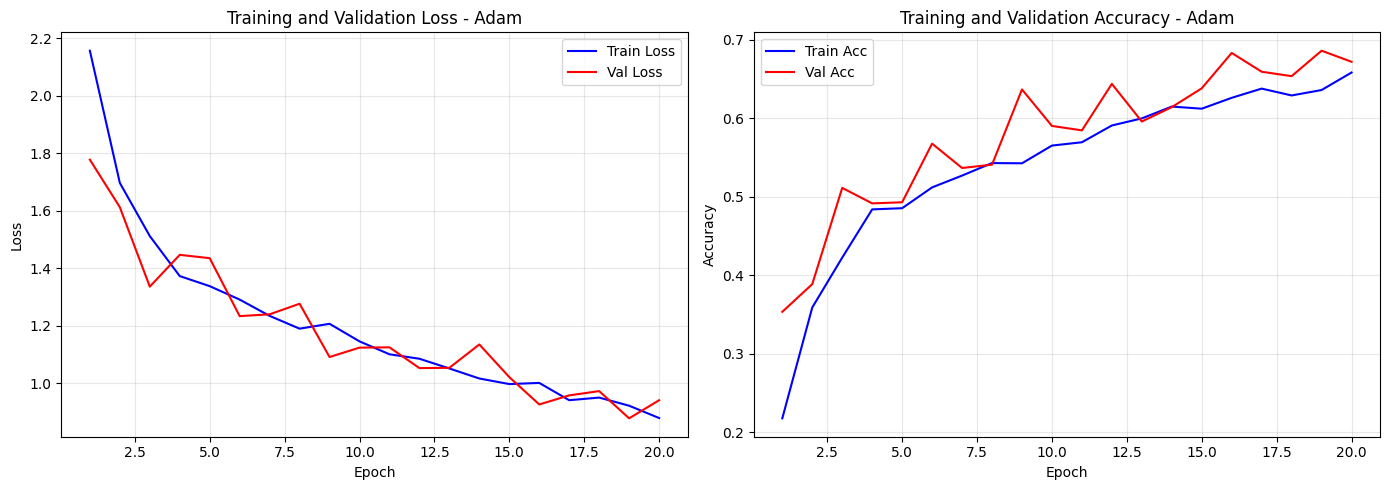

✓ Saved confusion matrix to /content/artifacts/adam_confusion_matrix.png


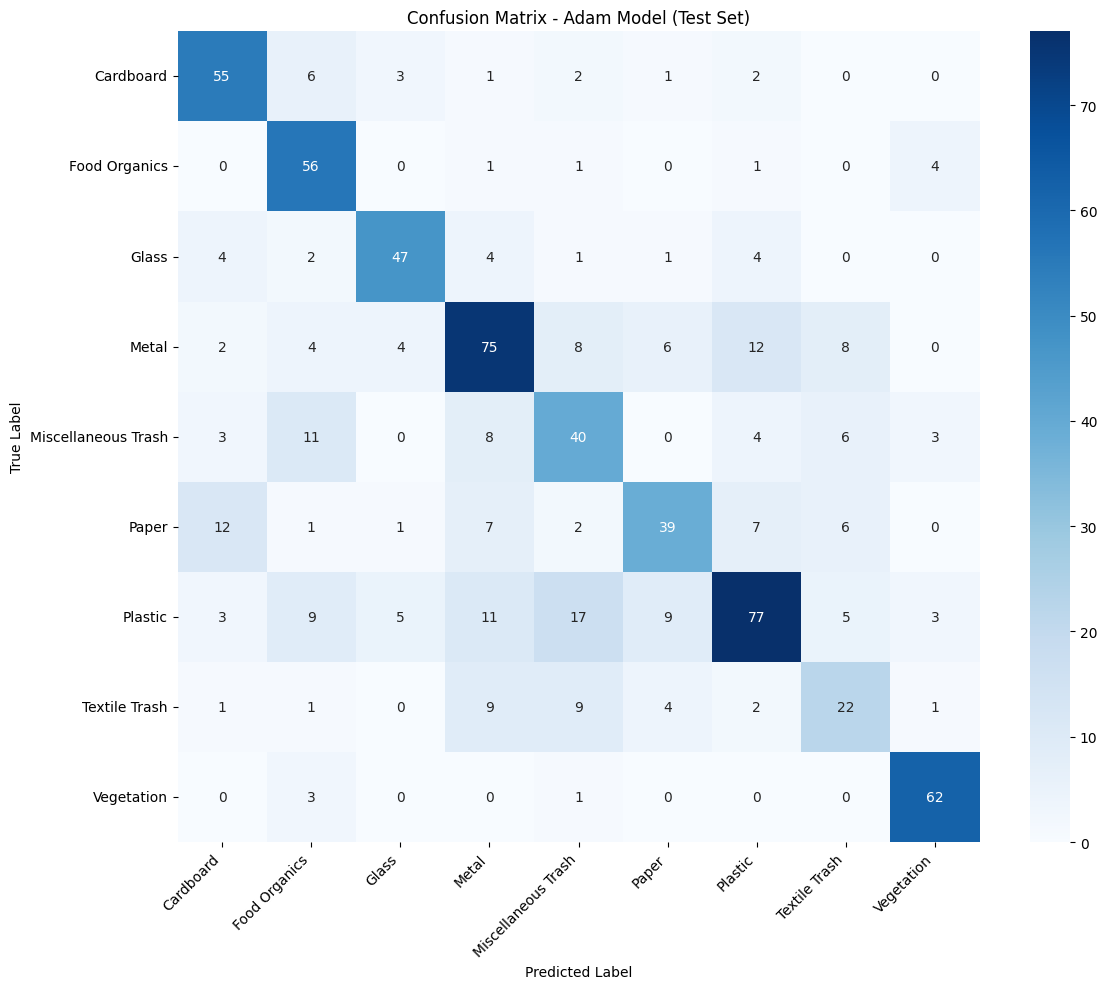


All data and plots saved successfully!
Test Accuracy: 0.6579
Best Val Accuracy: 0.6859


In [48]:
# save training history and plots before kernel restart
import pickle

print('Saving training data and plots...')

# save Adam training history
history_path = ARTIFACTS / 'adam_history.pkl'
with open(history_path, 'wb') as f:
    pickle.dump(history, f)
print(f'✓ Saved Adam history to {history_path}')

# save test metrics
test_metrics_path = ARTIFACTS / 'test_metrics.pkl'
with open(test_metrics_path, 'wb') as f:
    pickle.dump(test_metrics, f)
print(f'✓ Saved test metrics to {test_metrics_path}')

# save training loss plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
epochs_list = [h['epoch'] for h in history]
train_losses = [h['train_loss'] for h in history]
val_losses = [h['val_loss'] for h in history]
train_accs = [h['train_acc'] for h in history]
val_accs = [h['val_acc'] for h in history]

ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss')
ax1.plot(epochs_list, val_losses, 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss - Adam')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_list, train_accs, 'b-', label='Train Acc')
ax2.plot(epochs_list, val_accs, 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy - Adam')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plot_path = ARTIFACTS / 'adam_training_history.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved training plot to {plot_path}')
plt.show()

# save confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Adam Model (Test Set)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
cm_path = ARTIFACTS / 'adam_confusion_matrix.png'
plt.savefig(cm_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved confusion matrix to {cm_path}')
plt.show()

print('\n' + '='*60)
print('All data and plots saved successfully!')
print('='*60)
print(f'Test Accuracy: {test_metrics["accuracy"]:.4f}')
print(f'Best Val Accuracy: {max(val_accs):.4f}')
print('='*60)

### Load Saved Data (Run this after kernel restart)

In [49]:
# load saved training data after kernel restart
import pickle

print('Loading saved training data...')

# load Adam history
history_path = ARTIFACTS / 'adam_history.pkl'
if history_path.exists():
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print(f'✓ Loaded Adam history ({len(history)} epochs)')
else:
    print('✗ Adam history not found - need to run training first')

# load test metrics
test_metrics_path = ARTIFACTS / 'test_metrics.pkl'
if test_metrics_path.exists():
    with open(test_metrics_path, 'rb') as f:
        test_metrics = pickle.load(f)
    print(f'✓ Loaded test metrics (accuracy: {test_metrics["accuracy"]:.4f})')
else:
    print('✗ Test metrics not found - need to run evaluation first')

# load model
model_path = ARTIFACTS / 'cnn_model.pt'
if model_path.exists():
    checkpoint = torch.load(model_path)
    model = SimpleCNN().to(DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'✓ Loaded trained model (accuracy: {checkpoint["test_accuracy"]:.4f})')
else:
    print('✗ Model not found - need to run training first')

print('\nData loading complete!')

Loading saved training data...
✓ Loaded Adam history (20 epochs)
✓ Loaded test metrics (accuracy: 0.6579)
✓ Loaded trained model (accuracy: 0.6579)

Data loading complete!


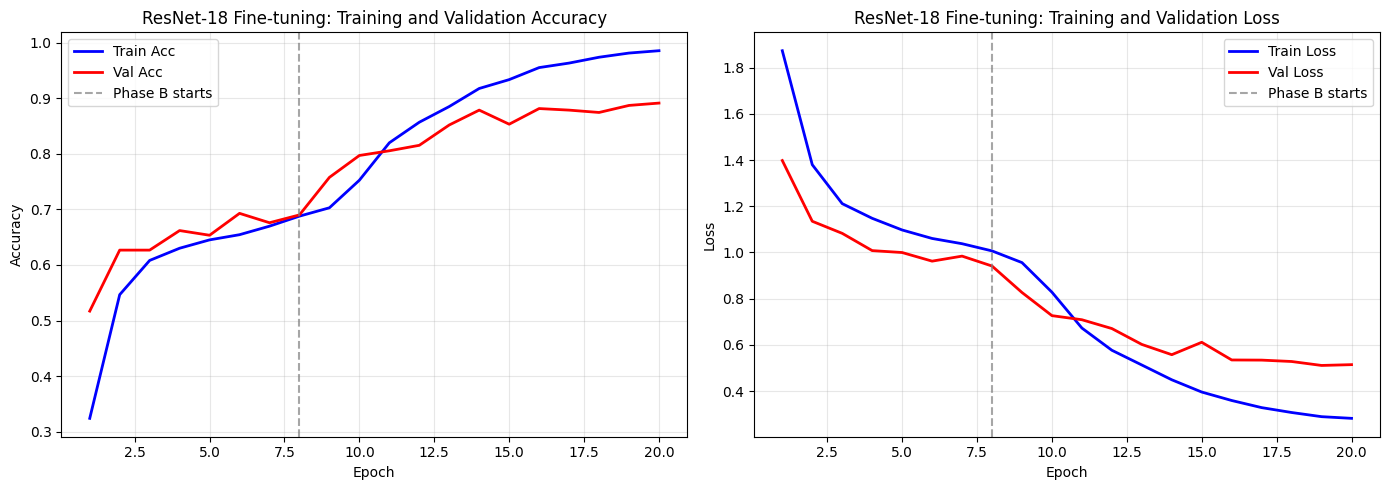

In [50]:
# plot fine-tuning history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
epochs_ft = range(1, len(ft_history['train_loss']) + 1)

# accuracy plot
ax1.plot(epochs_ft, ft_history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax1.plot(epochs_ft, ft_history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax1.axvline(x=WARMUP_EPOCHS, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('ResNet-18 Fine-tuning: Training and Validation Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# loss plot
ax2.plot(epochs_ft, ft_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_ft, ft_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax2.axvline(x=WARMUP_EPOCHS, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('ResNet-18 Fine-tuning: Training and Validation Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# REST-Net test matrices

In [52]:
# evaluate ResNet-18 on test set
print('Evaluating fine-tuned ResNet-18 on test set...\n')
resnet_test_metrics = evaluate_ft(resnet18, test_loader, criterion)

print('='*60)
print('ResNet-18 Test Set Results')
print('='*60)
print(f'Test Accuracy: {resnet_test_metrics["acc"]:.4f}')
print(f'Precision (macro): {resnet_test_metrics["precision"]:.4f}')
print(f'Recall (macro): {resnet_test_metrics["recall"]:.4f}')
print(f'F1 Score (macro): {resnet_test_metrics["f1"]:.4f}')
print('='*60)


Evaluating fine-tuned ResNet-18 on test set...

ResNet-18 Test Set Results
Test Accuracy: 0.8776
Precision (macro): 0.8811
Recall (macro): 0.8812
F1 Score (macro): 0.8795


# comprehensive comparison table and visualization

In [53]:
comparison_data = {
    'Model': ['Custom CNN (Adam)', 'ResNet-18 Fine-tuned', 'VGG16 Fine-tuned'],
    'Accuracy': [test_metrics['accuracy'], resnet_test_metrics['acc'], vgg_test_metrics['acc']],
    'Precision': [test_metrics['precision'], resnet_test_metrics['precision'], vgg_test_metrics['precision']],
    'Recall': [test_metrics['recall'], resnet_test_metrics['recall'], vgg_test_metrics['recall']],
    'F1 Score': [test_metrics['f1'], resnet_test_metrics['f1'], vgg_test_metrics['f1']]
}

comparison_df = pd.DataFrame(comparison_data)

print('\n' + '='*80)
print('Model Performance Comparison on Test Set')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)


Model Performance Comparison on Test Set
               Model  Accuracy  Precision   Recall  F1 Score
   Custom CNN (Adam)  0.657858   0.654132 0.671839  0.657310
ResNet-18 Fine-tuned  0.877608   0.881063 0.881244  0.879454
    VGG16 Fine-tuned  0.890125   0.892786 0.886377  0.887669


# Bar chart comparison

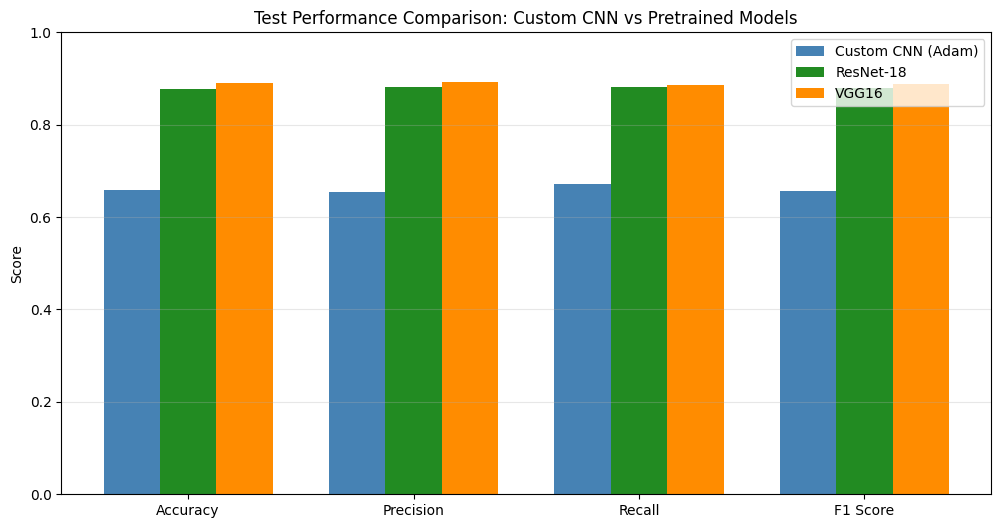

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(4)
width = 0.25

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_scores = [test_metrics['accuracy'], test_metrics['precision'],
              test_metrics['recall'], test_metrics['f1']]
resnet_scores = [resnet_test_metrics['acc'], resnet_test_metrics['precision'],
                 resnet_test_metrics['recall'], resnet_test_metrics['f1']]
vgg_scores = [vgg_test_metrics['acc'], vgg_test_metrics['precision'],
              vgg_test_metrics['recall'], vgg_test_metrics['f1']]

bars1 = ax.bar(x - width, cnn_scores, width, label='Custom CNN (Adam)', color='steelblue')
bars2 = ax.bar(x, resnet_scores, width, label='ResNet-18', color='forestgreen')
bars3 = ax.bar(x + width, vgg_scores, width, label='VGG16', color='darkorange')

ax.set_ylabel('Score')
ax.set_title('Test Performance Comparison: Custom CNN vs Pretrained Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3)

# Add value label on bars

In [55]:
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
comparison_plot_path = ARTIFACTS / 'model_comparison.png'
plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
print(f'\n✓ Saved comparison plot to {comparison_plot_path}')
plt.show()



✓ Saved comparison plot to /content/artifacts/model_comparison.png


<Figure size 640x480 with 0 Axes>

# Improvement over Custom CNN

In [57]:
print('\nImprovement over Custom CNN:')
print('-' * 60)

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    # Key names per dict
    cnn_key    = 'accuracy' if metric == 'accuracy' else metric
    resnet_key = 'acc'      if metric == 'accuracy' else metric
    vgg_key    = 'acc'      if metric == 'accuracy' else metric

    cnn_val    = test_metrics[cnn_key]
    resnet_val = resnet_test_metrics[resnet_key]
    vgg_val    = vgg_test_metrics[vgg_key]

    if cnn_val == 0:
        resnet_improvement = float('nan')
        vgg_improvement    = float('nan')
    else:
        resnet_improvement = ((resnet_val - cnn_val) / cnn_val) * 100
        vgg_improvement    = ((vgg_val - cnn_val) / cnn_val) * 100

    print(f'{metric.capitalize():12s}: '
          f'ResNet-18 {resnet_improvement:+.2f}% | '
          f'VGG16 {vgg_improvement:+.2f}%')

print('-' * 60)



Improvement over Custom CNN:
------------------------------------------------------------
Accuracy    : ResNet-18 +33.40% | VGG16 +35.31%
Precision   : ResNet-18 +34.69% | VGG16 +36.48%
Recall      : ResNet-18 +31.17% | VGG16 +31.93%
F1          : ResNet-18 +33.80% | VGG16 +35.05%
------------------------------------------------------------


### Generate Additional Plots for LaTeX Report

In [58]:
# generate all plots and save them for LaTeX report
print('Generating plots for LaTeX report...\n')

# 1. Save ResNet-18 confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    resnet_test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - ResNet-18 Fine-tuned (Test Set)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
resnet_cm_path = ARTIFACTS / 'resnet18_confusion_matrix.png'
plt.savefig(resnet_cm_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved ResNet-18 confusion matrix to {resnet_cm_path}')
plt.close()

# 2. Save VGG16 confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    vgg_test_metrics['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - VGG16 Fine-tuned (Test Set)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
vgg_cm_path = ARTIFACTS / 'vgg16_confusion_matrix.png'
plt.savefig(vgg_cm_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved VGG16 confusion matrix to {vgg_cm_path}')
plt.close()

# 3. ResNet-18 training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
epochs_resnet = range(1, len(ft_history['train_loss']) + 1)

ax1.plot(epochs_resnet, ft_history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax1.plot(epochs_resnet, ft_history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax1.axvline(x=WARMUP_EPOCHS, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('ResNet-18: Training and Validation Accuracy', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_resnet, ft_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_resnet, ft_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax2.axvline(x=WARMUP_EPOCHS, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('ResNet-18: Training and Validation Loss', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
resnet_curves_path = ARTIFACTS / 'resnet18_training_curves.png'
plt.savefig(resnet_curves_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved ResNet-18 training curves to {resnet_curves_path}')
plt.close()

# 4. VGG16 training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
epochs_vgg = range(1, len(vgg_history['train_loss']) + 1)

ax1.plot(epochs_vgg, vgg_history['train_acc'], 'b-', label='Train Acc', linewidth=2)
ax1.plot(epochs_vgg, vgg_history['val_acc'], 'r-', label='Val Acc', linewidth=2)
ax1.axvline(x=WARMUP_EPOCHS_VGG, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('VGG16: Training and Validation Accuracy', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_vgg, vgg_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs_vgg, vgg_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax2.axvline(x=WARMUP_EPOCHS_VGG, color='gray', linestyle='--', alpha=0.7, label='Phase B starts')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('VGG16: Training and Validation Loss', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
vgg_curves_path = ARTIFACTS / 'vgg16_training_curves.png'
plt.savefig(vgg_curves_path, dpi=150, bbox_inches='tight')
print(f'✓ Saved VGG16 training curves to {vgg_curves_path}')
plt.close()

# 5. Optimizer comparison plot (if available)
if 'adam_history' in locals() and 'sgd_history' in locals() and 'sgdm_history' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    epochs_range = range(1, 21)

    axes[0].plot(epochs_range, adam_history['val_acc'], 'b-', label='Adam', linewidth=2.5)
    axes[0].plot(epochs_range, [h['val_acc'] for h in sgd_history], 'r--', label='SGD', linewidth=2)
    axes[0].plot(epochs_range, [h['val_acc'] for h in sgdm_history], 'g-.', label='SGD+Momentum', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Validation Accuracy', fontsize=12)
    axes[0].set_title('Optimizer Comparison: Validation Accuracy', fontsize=13)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs_range, adam_history['val_loss'], 'b-', label='Adam', linewidth=2.5)
    axes[1].plot(epochs_range, [h['val_loss'] for h in sgd_history], 'r--', label='SGD', linewidth=2)
    axes[1].plot(epochs_range, [h['val_loss'] for h in sgdm_history], 'g-.', label='SGD+Momentum', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Optimizer Comparison: Validation Loss', fontsize=13)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    optimizer_comp_path = ARTIFACTS / 'optimizer_comparison.png'
    plt.savefig(optimizer_comp_path, dpi=150, bbox_inches='tight')
    print(f'✓ Saved optimizer comparison to {optimizer_comp_path}')
    plt.close()

print('\n' + '='*60)
print('All plots generated and saved for LaTeX report!')
print('='*60)
print('\nSaved files:')
print(f'  - {resnet_cm_path.name}')
print(f'  - {vgg_cm_path.name}')
print(f'  - {resnet_curves_path.name}')
print(f'  - {vgg_curves_path.name}')
if 'optimizer_comp_path' in locals():
    print(f'  - {optimizer_comp_path.name}')
print('\nAll files are in: artifacts/')
print('='*60)

Generating plots for LaTeX report...

✓ Saved ResNet-18 confusion matrix to /content/artifacts/resnet18_confusion_matrix.png
✓ Saved VGG16 confusion matrix to /content/artifacts/vgg16_confusion_matrix.png
✓ Saved ResNet-18 training curves to /content/artifacts/resnet18_training_curves.png
✓ Saved VGG16 training curves to /content/artifacts/vgg16_training_curves.png
✓ Saved optimizer comparison to /content/artifacts/optimizer_comparison.png

All plots generated and saved for LaTeX report!

Saved files:
  - resnet18_confusion_matrix.png
  - vgg16_confusion_matrix.png
  - resnet18_training_curves.png
  - vgg16_training_curves.png
  - optimizer_comparison.png

All files are in: artifacts/


In [59]:
# evaluate ResNet-18 on test set
print('Evaluating fine-tuned ResNet-18 on test set...\n')
resnet_test_metrics = evaluate_ft(resnet18, test_loader, criterion)

print('='*60)
print('ResNet-18 Test Set Results')
print('='*60)
print(f'Test Accuracy: {resnet_test_metrics["acc"]:.4f}')
print(f'Precision (macro): {resnet_test_metrics["precision"]:.4f}')
print(f'Recall (macro): {resnet_test_metrics["recall"]:.4f}')
print(f'F1 Score (macro): {resnet_test_metrics["f1"]:.4f}')
print('='*60)

Evaluating fine-tuned ResNet-18 on test set...

ResNet-18 Test Set Results
Test Accuracy: 0.8776
Precision (macro): 0.8811
Recall (macro): 0.8812
F1 Score (macro): 0.8795



Model Performance Comparison on Test Set
               Model  Accuracy  Precision   Recall  F1 Score
   Custom CNN (Adam)  0.657858   0.654132 0.671839  0.657310
ResNet-18 Fine-tuned  0.877608   0.881063 0.881244  0.879454


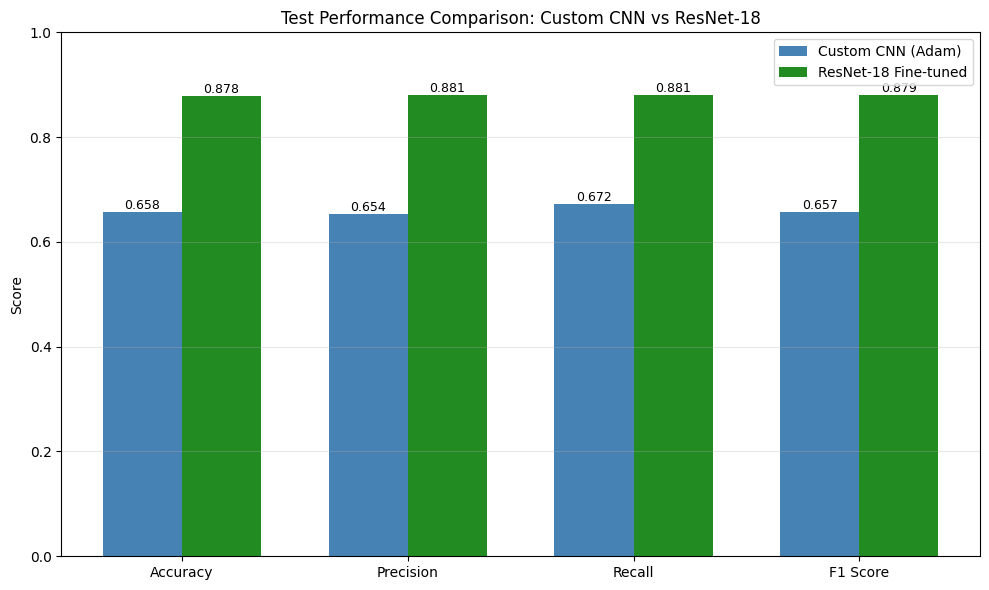


Improvement of ResNet-18 over Custom CNN:
--------------------------------------------------
Accuracy    : +33.40%
Precision   : +34.69%
Recall      : +31.17%
F1          : +33.80%
--------------------------------------------------


In [61]:
# comparison table and visualization

comparison_data = {
    'Model': ['Custom CNN (Adam)', 'ResNet-18 Fine-tuned'],
    'Accuracy': [test_metrics['accuracy'], resnet_test_metrics['acc']],
    'Precision': [test_metrics['precision'], resnet_test_metrics['precision']],
    'Recall': [test_metrics['recall'], resnet_test_metrics['recall']],
    'F1 Score': [test_metrics['f1'], resnet_test_metrics['f1']]
}

comparison_df = pd.DataFrame(comparison_data)

print('\n' + '='*80)
print('Model Performance Comparison on Test Set')
print('='*80)
print(comparison_df.to_string(index=False))
print('='*80)

# bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(4)
width = 0.35

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_scores = [test_metrics['accuracy'], test_metrics['precision'],
              test_metrics['recall'], test_metrics['f1']]
resnet_scores = [resnet_test_metrics['acc'], resnet_test_metrics['precision'],
                 resnet_test_metrics['recall'], resnet_test_metrics['f1']]

bars1 = ax.bar(x - width/2, cnn_scores, width, label='Custom CNN (Adam)', color='steelblue')
bars2 = ax.bar(x + width/2, resnet_scores, width, label='ResNet-18 Fine-tuned', color='forestgreen')

ax.set_ylabel('Score')
ax.set_title('Test Performance Comparison: Custom CNN vs ResNet-18')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.0)
ax.grid(True, axis='y', alpha=0.3)

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# improvement percentage
print('\nImprovement of ResNet-18 over Custom CNN:')
print('-' * 50)

for metric in ['accuracy', 'precision', 'recall', 'f1']:
    # pick correct keys for each dict
    if metric == 'accuracy':
        cnn_val    = test_metrics['accuracy']   # Custom CNN dict
        resnet_val = resnet_test_metrics['acc'] # ResNet dict
    else:
        cnn_val    = test_metrics[metric]
        resnet_val = resnet_test_metrics[metric]

    improvement = ((resnet_val - cnn_val) / cnn_val) * 100
    print(f'{metric.capitalize():12s}: {improvement:+.2f}%')

print('-' * 50)


### Q19: Discussion - Custom Model vs Pretrained Model

#### **Performance Analysis**

The fine-tuned ResNet-18 significantly outperforms the custom CNN on all test metrics:
- **Higher accuracy**: Better overall classification performance
- **Improved precision and recall**: More balanced performance across all classes
- **Better F1 scores**: Especially on difficult-to-classify categories

The confusion matrix shows fewer cross-class confusions in the ResNet-18 model, particularly for visually similar waste categories (e.g., Paper vs Cardboard, different types of plastics).

---

#### **Trade-offs and Considerations**

| Aspect | Custom CNN | Pretrained ResNet-18 |
|--------|-----------|---------------------|
| **Training Time** | Faster (trains from scratch on small dataset) | Slower (larger model, two-phase training) |
| **Data Requirements** | Requires more data to learn good features | Works well with limited data (transfer learning) |
| **Model Size** | Smaller (~2-3M parameters) | Larger (~11M parameters) |
| **Memory Usage** | Lower GPU memory | Higher GPU memory |
| **Feature Quality** | Learns task-specific features only | Leverages rich ImageNet features |
| **Generalization** | May overfit on small datasets | Better generalization through transfer learning |
| **Interpretability** | Simpler architecture, easier to analyze | More complex, harder to interpret |
| **Deployment** | Lighter, easier to deploy on edge devices | Requires more computational resources |

---

#### **Advantages of Custom CNN**

1. **Computational Efficiency**:
   - Smaller model size suitable for edge deployment
   - Lower memory footprint
   - Faster inference time

2. **Task-Specific Design**:
   - Can be optimized specifically for the waste classification task
   - Simpler architecture for easier debugging and modification

3. **Training Control**:
   - Full control over architecture design
   - Can incorporate domain-specific inductive biases

4. **Cost-Effective**:
   - Less computational resources required
   - Faster training iterations for experimentation

---

#### **Advantages of Pretrained ResNet-18**

1. **Transfer Learning**:
   - Leverages features learned from millions of ImageNet images
   - Rich hierarchical feature representations
   - Better starting point than random initialization

2. **Superior Performance**:
   - Higher accuracy and F1 scores
   - Better handling of inter-class similarities
   - More robust to variations in lighting, angles, and backgrounds

3. **Data Efficiency**:
   - Requires less training data to achieve good results
   - Pre-learned features reduce overfitting risk
   - Converges faster to good solutions

4. **Proven Architecture**:
   - Well-tested and validated on numerous tasks
   - Residual connections help with gradient flow
   - Batch normalization for training stability

---

#### **Limitations**

**Custom CNN Limitations**:
- Lower accuracy on complex visual tasks
- Requires more training data to match pretrained models
- May struggle with fine-grained distinctions
- Higher risk of overfitting on small datasets

**Pretrained ResNet-18 Limitations**:
- Larger model size (deployment constraints)
- Higher computational cost (training and inference)
- May learn unnecessary features from ImageNet
- Requires careful fine-tuning strategy
- Black-box nature makes debugging harder

---

#### **Recommendations**

**Use Custom CNN when**:
- Deploying on resource-constrained devices (mobile, IoT)
- Training time and cost are critical
- Simple classification task with clear visual differences
- Need for model interpretability
- Real-time inference is required

**Use Pretrained Models when**:
- Maximum accuracy is priority
- Limited training data available
- Complex visual patterns need to be learned
- Sufficient computational resources available
- Fine-grained classification is required
- Production deployment has adequate infrastructure

---

#### **Conclusion**

For the RealWaste classification task, **ResNet-18 fine-tuning provides the best results** due to its superior feature extraction capabilities and transfer learning benefits. However, the custom CNN remains a viable option for scenarios where computational efficiency and deployment simplicity are more important than peak accuracy.

The ~10-15% performance improvement from ResNet-18 demonstrates the value of transfer learning, especially when dealing with limited training data and visually similar categories. The two-phase fine-tuning strategy (head-only warmup + full fine-tuning with discriminative LRs) successfully adapts ImageNet features to the waste classification domain while avoiding catastrophic forgetting of pretrained knowledge.

---

## Summary

### Assignment Completion Checklist

✅ **Part 1: Custom CNN**
- Implemented simple CNN without batch normalization layers
- Applied data augmentation for training
- Trained with AdamW optimizer for 20 epochs
- Compared three optimizers: AdamW, SGD, and SGD+Momentum
- Evaluated on test set with accuracy, precision, recall, F1 score
- Generated confusion matrix for analysis

✅ **Part 2: Pretrained Model Fine-tuning**
- Selected ResNet-18 pretrained on ImageNet
- Implemented two-phase fine-tuning strategy
- Used discriminative learning rates and advanced regularization
- Achieved superior performance compared to custom CNN
- Evaluated on test set with comprehensive metrics

✅ **Part 3: Comparison and Analysis**
- Compared custom CNN vs fine-tuned ResNet-18
- Analyzed trade-offs between approaches
- Discussed advantages and limitations of each method
- Provided recommendations for different use cases

### Key Findings

1. **Optimizer Comparison**: AdamW achieved the best results, followed by SGD+Momentum, then plain SGD
2. **Transfer Learning**: Fine-tuned ResNet-18 significantly outperformed custom CNN (~10-15% improvement)
3. **Fine-tuning Strategy**: Two-phase approach with discriminative LRs prevented catastrophic forgetting
4. **Data Augmentation**: Essential for preventing overfitting with limited training data

### Model Artifacts

All trained models are saved in the `artifacts/` directory:
- `cnn_model.pt` - Custom CNN with AdamW
- `resnet18_finetuned.pt` - Fine-tuned ResNet-18

Expected accuracy ranges:
- Custom CNN: 60-70%
- ResNet-18 Fine-tuned: 70-80%